In [29]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10,2)
mpl.rcParams['axes.grid'] = False

#test

In [30]:
pathCSV = r'ProcessedDataCenterHall.csv'
df = pd.read_csv(pathCSV, index_col=0, parse_dates=True)

In [31]:
df=df.resample('15Min').mean()

In [32]:
df.head()

,RealPower,ReactivePower
DateTime,,
2016-01-07 10:45:00,170.721,63.393
2016-01-07 11:00:00,182.143,71.259
2016-01-07 11:15:00,182.652,70.958
2016-01-07 11:30:00,177.763,68.534
2016-01-07 11:45:00,174.452,69.953


In [33]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [34]:
adf_test(df['RealPower'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.719418e+01
p-value                 6.522789e-30
# lags used             7.500000e+01
# observations          1.453210e+05
critical value (1%)    -3.430395e+00
critical value (5%)    -2.861560e+00
critical value (10%)   -2.566781e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [35]:
adf_test(df['ReactivePower'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.751129e+01
p-value                 4.333627e-30
# lags used             7.500000e+01
# observations          1.453210e+05
critical value (1%)    -3.430395e+00
critical value (5%)    -2.861560e+00
critical value (10%)   -2.566781e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [36]:
# Uncomment if you want to train and test whole dataset
# test_obs = int(0.9*(len(df)))
# train = df[:test_obs]
# test = df[test_obs:]

# Uncomment if you want to train and test last 100 data
test_obs = 4
train = df[-50000:-test_obs]
test = df[-test_obs:]

In [37]:
train.shape

(49996, 2)

In [38]:
for i in range(100):
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 0
AIC:  10.737486870480762
BIC:  10.737839686637303

Order = 1
AIC:  4.387510715423368
BIC:  4.3885691826636215

Order = 2
AIC:  4.317382888553877
BIC:  4.319147031906521

Order = 3
AIC:  4.298268062141946
BIC:  4.300737906637066

Order = 4
AIC:  4.288544788754616
BIC:  4.291720359423702

Order = 5
AIC:  4.261047385743511
BIC:  4.264928707619461

Order = 6
AIC:  4.2548452248513
BIC:  4.259432322968415

Order = 7
AIC:  4.2459313206745275
BIC:  4.251224220068519

Order = 8
AIC:  4.234401833104594
BIC:  4.240400558812576

Order = 9
AIC:  4.213456814118861
BIC:  4.220161391179356

Order = 10
AIC:  4.207614811723065
BIC:  4.215025265176003

Order = 11
AIC:  4.205349818676253
BIC:  4.213466173562968

Order = 12
AIC:  4.2029256451961645
BIC:  4.2117479265594

Order = 13
AIC:  4.184458265938859
BIC:  4.193986498822764

Order = 14
AIC:  4.183905790983447
BIC:  4.1941400004335785

Order = 15
AIC:  4.182514471967885
BIC:  4.193454683031207

Order = 16
AIC:  4.180815677216043
BIC:  4.19246

In [39]:
model.select_order(100).summary()

,AIC,BIC,FPE,HQIC
0,10.74,10.74,4.600e+04,10.74
1,4.386,4.388,80.36,4.387
2,4.316,4.318,74.91,4.317
3,4.297,4.300,73.50,4.298
4,4.288,4.291,72.79,4.289
5,4.260,4.264,70.80,4.261
6,4.254,4.258,70.36,4.255
7,4.245,4.250,69.73,4.246
8,4.233,4.239,68.93,4.235
9,4.212,4.219,67.49,4.214


In [40]:
result = model.fit(98)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 17, Jan, 2022
Time:                     21:41:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.65197
Nobs:                     49898.0    HQIC:                   3.60416
Log likelihood:          -230586.    FPE:                    35.9578
AIC:                      3.58235    Det(Omega_mle):         35.6755
--------------------------------------------------------------------
Results for equation RealPower
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     1.933675         0.140730           13.740           0.000
L1.RealPower              1.026576         0.007565          135.697           0.000
L1.ReactivePower          0.007969      

In [41]:
lagged_Values = train.values[-98:]

In [42]:
test_original = df[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)
pred = result.forecast(y=lagged_Values, steps=test_obs) 
print("pred: ", pred)
# idx = pd.date_range('2016-06-06 21:00:00', periods=test_obs, freq='1H') # Uncomment if testing all test data
# idx = pd.date_range('2020-02-29 12:00:00', periods=test_obs, freq='15Min') # Uncomment if testing last 12 data
df_forecast=pd.DataFrame(data=pred, index=test_original.index, columns=['realPower_2d', 'reactivePower_2d'])
print("df_forecast una: ", df_forecast)

pred:  [[119.91694631  61.0263849 ]
 [ 98.61874217  52.48847031]
 [ 95.39147877  51.01901812]
 [ 95.24028116  50.7518633 ]]
df_forecast una:                       realPower_2d  reactivePower_2d
DateTime                                           
2020-02-29 23:00:00    119.916946         61.026385
2020-02-29 23:15:00     98.618742         52.488470
2020-02-29 23:30:00     95.391479         51.019018
2020-02-29 23:45:00     95.240281         50.751863


In [43]:
# test_original = df[-test_obs:]
# test_original.index = pd.to_datetime(test_original.index)
# print("test original: ", test_original)
# print("predicted original: ", df_forecast)

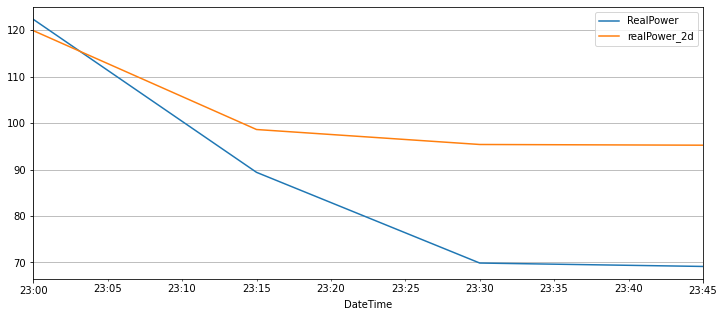

In [44]:
test_original['RealPower'].plot(figsize=(12,5),legend=True, grid=True)
df_forecast['realPower_2d'].plot(legend=True, grid=True)

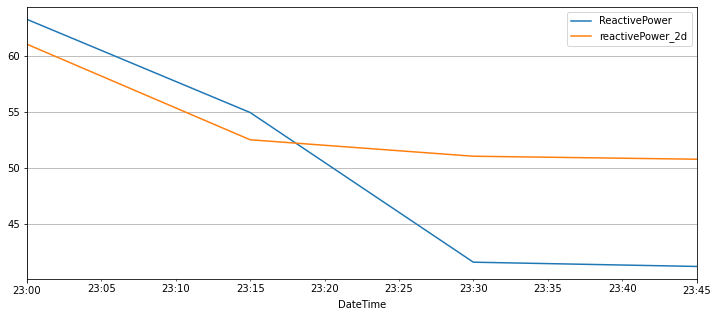

In [45]:
test_original['ReactivePower'].plot(figsize=(12,5),legend=True, grid=True)
df_forecast['reactivePower_2d'].plot(legend=True, grid=True)

In [46]:
# df_forecast['RealPower1d'] = (df['RealPower'].iloc[-test_obs-1]-df['RealPower'].iloc[-test_obs-2]) + df_forecast['realPower_2d'].cumsum()
# print("df_forecast unang una: ", df_forecast)
# df_forecast['RealPowerForecast'] = df['RealPower'].iloc[-test_obs-1] + df_forecast['RealPower1d'].cumsum()
# print("df_forecast pangalawa: ", df_forecast)

In [47]:
# df_forecast['ReactivePower1d'] = (df['ReactivePower'].iloc[-test_obs-1]-df['ReactivePower'].iloc[-test_obs-2]) + df_forecast['reactivePower_2d'].cumsum()
# df_forecast['ReactivePowerForecast'] = df['ReactivePower'].iloc[-test_obs-1] + df_forecast['ReactivePower1d'].cumsum()

In [48]:
# test_original = df[-test_obs:]
# test_original.index = pd.to_datetime(test_original.index)
# print("test original: ", test_original)
# print("predicted original: ", df_forecast)

In [49]:
# test_original['RealPower'].plot(figsize=(12,5),legend=True)
# df_forecast['RealPowerForecast'].plot(legend=True)